<a href="https://colab.research.google.com/github/keinam53/Machine_learning/blob/main/Uczenie_nienadzorowane/5_Case_studies/1_Segmentacja_klientow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Segmentacja klientow
1. [Import bibliotek](#0)
2. [Załadowanie danych](#1)
3. [Eksploracja danych](#2)
4. [Wyznacznie retencji klienta](#3)
5. [Retencja - KMeans](#4)
6. [Retencja - DBSCAN](#5)
7. [Sprzedaż](#6)
8. [Sprzedaż - KMeans](#7)
9. [Sprzedaż - DBSCAN](#8)
10. [Retencja, sprzedaż - KMeans](#9)

### <a name='0'></a> Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

### <a name='1'></a> Załadowanie danych

In [2]:
url = 'https://storage.googleapis.com/esmartdata-courses-files/ml-course/OnlineRetail.csv'
raw_data = pd.read_csv(url, encoding='latin', parse_dates=['InvoiceDate'])
data = raw_data.copy()
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### <a name='2'></a> Eksploracja danych

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
data.describe(include=['object'])

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


In [6]:
data.describe(datetime_is_numeric=True)

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156151552,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
#Usunięcie braków
data.dropna(inplace=True)
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [10]:
data['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [11]:
tmp = data['Country'].value_counts().nlargest(10).reset_index()
tmp.columns = ['Country', 'Count']
px.bar(tmp, 'Country', 'Count', width=950, template='plotly_dark', 
       title='Częstotliwość zakupów - podział na kraje')

In [12]:
#Obcięcid danych do UK
filter = data['Country'] == 'United Kingdom'
data_uk = data[filter]
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
data_uk['Country'].value_counts()

United Kingdom    361878
Name: Country, dtype: int64

In [14]:
#Utworzenie nowej zmiennej Sales
data_uk['Sales'] = data_uk['Quantity'] * data_uk['UnitPrice']
data_uk.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [15]:
#Częstotliwość zakupów ze względu na dzień
tmp = data_uk.groupby(data_uk['InvoiceDate'].dt.date)['CustomerID'].count().reset_index()
tmp.columns = ['InvoiceDate', 'Count']
tmp.head()

,InvoiceDate,Count
0,2010-12-01,1809
1,2010-12-02,2029
2,2010-12-03,937
3,2010-12-05,2492
4,2010-12-06,1915


In [16]:
px.line(tmp, 'InvoiceDate', 'Count', width=950, template='plotly_dark', title='Częstotliwość zakupów ze względu na dzień')

In [17]:
# Łączna sprzedaż ze względu na dzień
tmp = data_uk.groupby(data_uk['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
tmp.head()

,InvoiceDate,Sales
0,2010-12-01,42030.85
1,2010-12-02,45622.08
2,2010-12-03,17512.44
3,2010-12-05,25458.85
4,2010-12-06,29007.74


In [18]:
px.line(tmp, 'InvoiceDate', 'Sales', width=950, template='plotly_dark', title='Łączna sprzedaż ze względu na dzień')

### <a name='3'></a> Wyznacznie retencji klienta

In [19]:
data_user = pd.DataFrame(data['CustomerID'].unique(), columns=['CustomerID'])
data_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [20]:
data_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


In [21]:
#Wydobycie daty ostatniego zakupu dla każdego klienta
last_purchase = data_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [22]:
print(last_purchase['LastPurchaseDate'].max())
print()
print(last_purchase['LastPurchaseDate'].min())

2011-12-09 12:49:00

2010-12-01 09:53:00


In [23]:
#Wyznaczenie retencji jako liczby dni od daty ostatniego kupna klienta do maksymalnej (ostatniej) daty kupna w danych
last_purchase['Retention'] = (last_purchase['LastPurchaseDate'].max() - last_purchase['LastPurchaseDate']).dt.days
last_purchase.head()

,CustomerID,LastPurchaseDate,Retention
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [24]:
last_purchase['Retention'].value_counts().nlargest(10)

3     114
8      97
0      97
2      92
1      77
7      67
10     66
9      64
17     59
16     53
Name: Retention, dtype: int64

In [25]:
px.histogram(last_purchase, 'Retention', template='plotly_dark', nbins=100, title='Retencja', width=950)

In [26]:
#Połączenie CustomerID z Retencją
data_user = pd.merge(data_user, last_purchase, on='CustomerID')
data_user = data_user[['CustomerID', 'Retention']]
data_user.head()

,CustomerID,Retention
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [27]:
px.scatter(data_user, 'CustomerID', 'Retention', width=950, template='plotly_dark', title=('Rozkład retencji klientów'))

In [28]:
data_retention = data_user[['Retention']]
data_retention.head()

,Retention
0,301
1,31
2,95
3,329
4,25


In [29]:
#Standaryzacja danych
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_user['RetentionScaled'] = scaler.fit_transform(data_retention)
data_user.head()

,CustomerID,Retention,RetentionScaled
0,17850.0,301,2.097649
1,13047.0,31,-0.596486
2,13748.0,95,0.042124
3,15100.0,329,2.377041
4,15291.0,25,-0.656356


In [30]:
px.scatter(data_user, 'CustomerID', 'RetentionScaled', width=950, template='plotly_dark', 
           title=('Rozkład wyskalowanej retencji klientów'))

In [31]:
data_retention_scaled = data_user[['RetentionScaled']]
data_retention_scaled.head()

,RetentionScaled
0,2.097649
1,-0.596486
2,0.042124
3,2.377041
4,-0.656356


### <a name='4'></a> Retencja - KMeans

In [32]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, max_iter=1000)
    kmeans.fit(data_retention_scaled)
    wcss.append(kmeans.inertia_)
  
wcss = pd.DataFrame(data=np.c_[range(1, 10), wcss], columns=[['NumberOfClusters', 'WCSS']])
wcss

,NumberOfClusters,WCSS
0,1.0,3950.000000
1,2.0,814.413936
2,3.0,387.846731
3,4.0,221.025615
4,5.0,136.371630
5,6.0,94.775258
6,7.0,71.033280
7,8.0,54.278419
8,9.0,40.947955


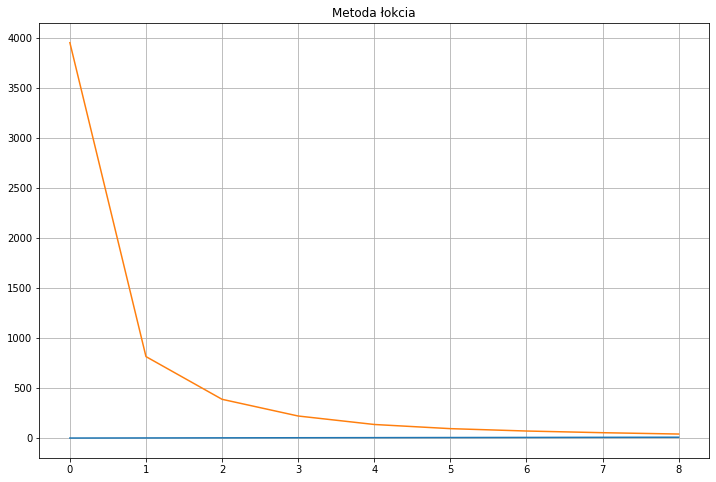

In [33]:
wcss.plot(kind='line', figsize=(12, 8), legend=False, title='Metoda łokcia', grid=True)

In [34]:
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(data_retention_scaled)

data_user['Cluster'] = kmeans.labels_
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster
0,17850.0,301,2.097649,1
1,13047.0,31,-0.596486,0
2,13748.0,95,0.042124,2
3,15100.0,329,2.377041,1
4,15291.0,25,-0.656356,0


In [35]:
tmp = data_user.groupby('Cluster')['Retention'].describe()
tmp

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2651.0,30.307808,24.994104,0.0,9.0,24.0,49.00,91.0
1,564.0,293.684397,45.612310,224.0,255.0,286.5,326.75,373.0
2,735.0,153.185034,38.155512,92.0,119.0,153.0,185.00,222.0


In [36]:
px.scatter(data_user, 'CustomerID', 'Retention', color='Cluster', template='plotly_dark', width=950, 
           title='KMeans - wizualizacja')

In [37]:
tmp = data_user['Cluster'].value_counts().reset_index()
tmp.columns = ['Cluster', 'Count']

px.bar(tmp, 'Cluster', 'Count', template='plotly_dark', width=950, title='Rozkład klastrów')

### <a name='5'></a> Retencja - DBSCAN

In [38]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.03, min_samples=5)
dbscan.fit(data_retention_scaled)

data_user['Cluster'] = dbscan.labels_
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster
0,17850.0,301,2.097649,0
1,13047.0,31,-0.596486,1
2,13748.0,95,0.042124,1
3,15100.0,329,2.377041,0
4,15291.0,25,-0.656356,1


In [39]:
px.scatter(data_user, 'CustomerID', 'Retention', color='Cluster', template='plotly_dark', width=950, 
           title='DBSCAN - wizualizacja')

### <a name='6'></a> Sprzedaż

In [40]:
data_sales = data_uk.groupby('CustomerID')['Sales'].sum().reset_index()
data_sales.head()

,CustomerID,Sales
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [41]:
data_user = pd.merge(data_user, data_sales, on='CustomerID')
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales
0,17850.0,301,2.097649,0,5288.63
1,13047.0,31,-0.596486,1,3079.10
2,13748.0,95,0.042124,1,948.25
3,15100.0,329,2.377041,0,635.10
4,15291.0,25,-0.656356,1,4596.51


In [42]:
scaler = StandardScaler()
data_user['SalesScaled'] = scaler.fit_transform(data_user[['Sales']])
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales,SalesScaled
0,17850.0,301,2.097649,0,5288.63,0.546024
1,13047.0,31,-0.596486,1,3079.10,0.208577
2,13748.0,95,0.042124,1,948.25,-0.116854
3,15100.0,329,2.377041,0,635.10,-0.164680
4,15291.0,25,-0.656356,1,4596.51,0.440321


In [43]:
px.scatter(data_user, 'CustomerID', 'SalesScaled', template='plotly_dark', width=950, 
           title='Sprzedzą w rozbiciu na klienta - dane przeskalowane')

In [44]:
data_sales_scaled = data_user[['SalesScaled']]
data_sales_scaled.head()

,SalesScaled
0,0.546024
1,0.208577
2,-0.116854
3,-0.164680
4,0.440321


### <a name='7'></a> Sprzedaż - KMeans

In [45]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, max_iter=1000)
    kmeans.fit(data_sales_scaled)
    wcss.append(kmeans.inertia_)

wcss = pd.DataFrame(data=np.c_[range(1, 10), wcss], columns=[['NumberOfCluster', 'WCSS']])
wcss

,NumberOfCluster,WCSS
0,1.0,3950.000000
1,2.0,1685.972621
2,3.0,595.548482
3,4.0,354.491493
4,5.0,220.976998
5,6.0,159.883307
6,7.0,104.450872
7,8.0,75.892481
8,9.0,53.519916


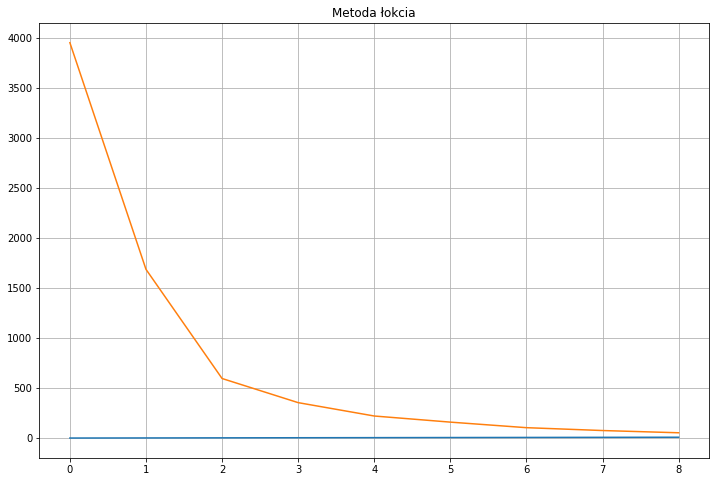

In [46]:
wcss.plot(kind='line', figsize=(12, 8), legend=False, grid=True, title='Metoda łokcia')

In [47]:
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(data_sales_scaled)

data_user['Cluster'] = kmeans.labels_
data_user['Cluster'] = data_user['Cluster'].astype(str)
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales,SalesScaled
0,17850.0,301,2.097649,0,5288.63,0.546024
1,13047.0,31,-0.596486,0,3079.10,0.208577
2,13748.0,95,0.042124,0,948.25,-0.116854
3,15100.0,329,2.377041,0,635.10,-0.164680
4,15291.0,25,-0.656356,0,4596.51,0.440321


In [48]:
px.scatter(data_user, 'CustomerID', 'SalesScaled', color='Cluster', template='plotly_dark', width=950, 
           title='Klastry sprzedaży  - dane przeskalowane')

In [49]:
kmeans.cluster_centers_

array([[-0.06065062],
       [33.63689221],
       [ 6.31619638]])

### <a name='8'></a> Sprzedaż - DBSCAN

In [60]:
dbscan = DBSCAN(eps=0.5, min_samples=7)
dbscan.fit(data_sales_scaled)

data_user['Cluster'] = dbscan.labels_
data_user['Cluster'] = data_user['Cluster'].astype(str)
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales,SalesScaled
0,17850.0,301,2.097649,0,5288.63,0.546024
1,13047.0,31,-0.596486,0,3079.10,0.208577
2,13748.0,95,0.042124,0,948.25,-0.116854
3,15100.0,329,2.377041,0,635.10,-0.164680
4,15291.0,25,-0.656356,0,4596.51,0.440321


In [61]:
px.scatter(data_user, 'CustomerID', 'SalesScaled', color='Cluster', template='plotly_dark', width=950, 
           title='Klastry sprzedaży (DBSCAN) - dane przeskalowane')

### <a name='9'></a> Retencja, sprzedaż - KMeans

In [62]:
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales,SalesScaled
0,17850.0,301,2.097649,0,5288.63,0.546024
1,13047.0,31,-0.596486,0,3079.10,0.208577
2,13748.0,95,0.042124,0,948.25,-0.116854
3,15100.0,329,2.377041,0,635.10,-0.164680
4,15291.0,25,-0.656356,0,4596.51,0.440321


In [64]:
px.scatter(data_user, 'RetentionScaled', 'SalesScaled', template='plotly_dark', width=950, 
           title='Retencja vs Sprzedaż - dane przeskalowane')

In [65]:
data_scaled = data_user[['RetentionScaled', 'SalesScaled']]
data_scaled.head()

,RetentionScaled,SalesScaled
0,2.097649,0.546024
1,-0.596486,0.208577
2,0.042124,-0.116854
3,2.377041,-0.164680
4,-0.656356,0.440321


In [66]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, max_iter=1000)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

wcss = pd.DataFrame(data=np.c_[range(1, 10), wcss], columns=[['NumberOfCluster', 'WCSS']])
wcss

,NumberOfCluster,WCSS
0,1.0,7900.000000
1,2.0,4714.239225
2,3.0,2458.449395
3,4.0,1383.090602
4,5.0,953.202349
5,6.0,730.476945
6,7.0,566.335318
7,8.0,445.457301
8,9.0,360.740900


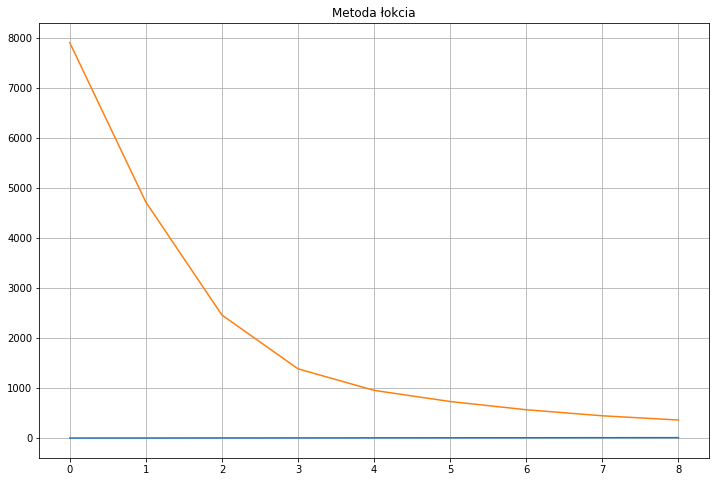

In [67]:
wcss.plot(kind='line', figsize=(12, 8), legend=False, grid=True, title='Metoda łokcia')

In [68]:
kmeans = KMeans(n_clusters=5, max_iter=1000)
kmeans.fit(data_scaled)

data_user['Cluster'] = kmeans.labels_
data_user['Cluster'] = data_user['Cluster'].astype(str)
data_user.head()

,CustomerID,Retention,RetentionScaled,Cluster,Sales,SalesScaled
0,17850.0,301,2.097649,4,5288.63,0.546024
1,13047.0,31,-0.596486,1,3079.10,0.208577
2,13748.0,95,0.042124,0,948.25,-0.116854
3,15100.0,329,2.377041,4,635.10,-0.164680
4,15291.0,25,-0.656356,1,4596.51,0.440321


In [69]:
px.scatter(data_user, 'RetentionScaled', 'SalesScaled', color='Cluster', template='plotly_dark', width=950, 
           title='Retencja vs Sprzedaż (KMEAN) - dane przeskalowane')

In [70]:
centroids = kmeans.cluster_centers_
centroids

array([[ 6.22357161e-01, -1.65974222e-01],
       [-6.00569901e-01, -5.15993073e-04],
       [-8.70889226e-01,  3.36368922e+01],
       [-8.48160918e-01,  6.31619638e+00],
       [ 2.02465229e+00, -2.02955850e-01]])

In [71]:
fig = px.scatter(data_user, x='RetentionScaled', y='SalesScaled', color='Cluster', template='plotly_dark', width=900,
                 title='KMeans - Wizualizacja klastrów + centroidy')
fig.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1], mode='markers', marker_symbol='star',
                         marker_size=10, marker_color='white', showlegend=False))

In [75]:
desc = data_user.groupby('Cluster')[['Retention', 'Sales']].describe()
desc

Retention                         ...       Sales                        
            count        mean        std  ...         50%          75%        max
Cluster                                   ...                                    
0           735.0  153.149660  38.210651  ...     391.760     768.5950    7092.06
1          2622.0   30.590770  25.004417  ...     911.205    2052.7950   21086.30
2             2.0    3.500000   4.949747  ...  221960.330  239199.4100  256438.49
3            27.0    5.777778   9.082245  ...   36351.420   53489.7900   88125.38
4           564.0  293.684397  45.612310  ...     249.930     391.9725   21535.90

[5 rows x 16 columns]

In [77]:
tmp = pd.merge(desc['Retention'][['count', 'mean']].reset_index(), desc['Sales'][['mean']].reset_index(), on='Cluster',
         suffixes=('_Retention', '_Sales'))
tmp

,Cluster,count,mean_Retention,mean_Sales
0,0,735.0,153.149660,626.623103
1,1,2622.0,30.590770,1710.007061
2,2,2.0,3.500000,221960.330000
3,3,27.0,5.777778,43070.445185
4,4,564.0,293.684397,384.475567


In [81]:
px.bar(tmp, 'count', 'Cluster', orientation='h', hover_data=['mean_Retention', 'mean_Sales'], template='plotly_dark',
       title='Rozkład klastrów')

Grupowanie hierarchiczne

In [91]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=3)
agglo.fit_predict(data_sales_scaled)

data_user['Cluster'] = agglo.labels_
data_user['Cluster'] = data_user['Cluster'].astype(str)
data_user.head()

px.scatter(data_user, 'CustomerID', 'SalesScaled', color='Cluster', template='plotly_dark', width=950, 
           title='Klastry sprzedaży (Grupowanie hier) - dane przeskalowane')